# Measuring electron temperature with a swept Langmuir probe

Written by Katerina Hromasova with input from Martina Lauerova, Georgiy Sarancha, Jan Stockel, Vojtech Svoboda, Michael Komm and others.


## Theory of swept probe measurements

The following figure shows the ideal Langmuir probe $I$-$V$ characteristic.

<img src="http://golem.fjfi.cvut.cz/wiki/Diagnostics/ParticleFlux/BallPenProbe/IV_characteristics.png" width="500">

The ion branch of the curve (left half of the plot) can be described by a three-parameter exponential function.

$I(V) = I_{sat} \left( 1 - \exp \left( -\frac{V - V_f}{T_e} \right)\right)$

The three parameters are the ion saturated current $I_{sat}$, the probe floating potential $V_f$ and the electron temperature $T_e$ \[eV\]. The shape of the characteristic changes depending on these parameters, and by fitting an experimental $I$-$V$ characteristic with an exponential function, one may retrieve their values.

To collect the whole $I$-$V$ characteristic in experiment, the biasing voltage $V$ on the probe is swept (i.e. varied periodically). The exact voltage shape is irrelevant, though we most often encounter the sawtooth (zig-zag) shape and the sine shape. The biasing voltage $V$ is then plotted against the current $I$ flowing from the probe to the ground and the curve is fitted with the exponential.

This notebook performs $I$-$V$ characteristic fitting throughout the current discharge. It documents the process step by step and concludes with drawing the temporal evolution of the ion saturated current $I_{sat}$, the probe floating potential $V_f$ and the electron temperature $T_e$.

**Note: All the time variables are given in seconds.**

## Import the basic libraries

First we import basic libraries: Numpy and Matplotlib. We will import more libraries throughout the notebook as needed.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Pick the discharge to analyse
shot_no = 35495 #35428  #test discharge for which the notebook will definitely work
shot = shot_no

## Access the diagnostics data

The Langmuir probe we shall be working with is placed on the PetiProbe.

<img src="http://golem.fjfi.cvut.cz/wiki/Diagnostics/ParticleFlux/PetiProbe/PG/0419PM/IMG_20190409_185157.jpg" width="300">

(The Langmuir probe is the small metal pin on the right.)

The data directory of the PetiProbe is `http://golem.fjfi.cvut.cz/shots/{shot}/Diagnostics/PetiProbe/`. Here, we write the function `get_data` to download the data.

In [2]:
from urllib.error import HTTPError # recognise the error stemming from missing data
import pandas as pd # for reading csv files

#Define an exception which will be raised if the data is missing and stop the notebook execution
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def get_data(shot, identifier):
    URL = "http://golem.fjfi.cvut.cz/shots/{shot}/Diagnostics/PetiProbe/{identifier}.csv"
    url = URL.format(shot=shot, identifier=identifier)
    try:
        df = pd.read_csv(url, names=['time', identifier], index_col='time')
    except HTTPError:
        print('File not found at %s. Aborting notebook execution.' % url)
        raise StopExecution
    t = np.array(df.index)
    data = np.transpose(np.array(df))[0]
    return t, data

The biasing voltage $V$ is collected under the name `U_bias`. The voltage proportional to the probe current is called `U_current`. The probe current can be calculated as $I = V/R$, where $R=46.7 \, \Omega$ is the measuring resistor resistance.

In the following, we load this data for the current shot, calculate the probe current $I$ and plot the time evolution of $I$ and $V$. Notice that at the discharge beginning, the current isn't flat zero. This is the effect of the parasitic current, which we will discuss shortly.

Probe current: 0 infinities removed
Probe voltage: 0 infinities removed


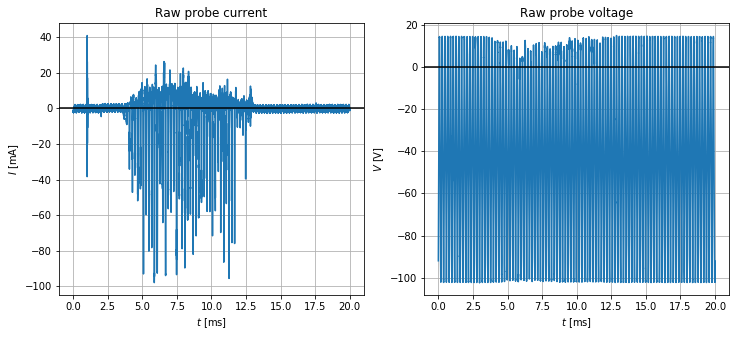

In [3]:
#Load the probe data
t, U_bias = get_data(shot, 'U_bias')
t, U_current = get_data(shot, 'U_current')
I = U_current/46.7 #probe current
V = U_bias # probe voltage

#Prepare the figure
fig = plt.figure('Time evolution of the raw probe data', figsize=(12,5))
fig.tight_layout()

#Plot the probe current
ax1 = plt.subplot(121)
ax1.set_title('Raw probe current')
plt.plot(t*1000, I*1000)
plt.xlabel('$t$ [ms]')
plt.ylabel('$I$ [mA]')
plt.grid(True)
plt.axhline(c='k')

#Plot the probe voltage
ax2 = plt.subplot(122)
ax2.set_title('Raw probe voltage')
plt.plot(t*1000, V)
plt.xlabel('$t$ [ms]')
plt.ylabel('$V$ [V]')
plt.grid(True)
plt.axhline(c='k')

# Cut all the signals so that they start at t=0 (for later calculation purposes)
I = I[t>=0]
V = V[t>=0]
t = t[t>=0]

# Remove infinities and NaNs from the signals
def remove_bad_numbers(data):
    n_bad = np.sum(np.isnan(data) | np.isinf(data))
    if np.isnan(data[0]) or np.isinf(data[0]):
        data[0] = 0
    for i in range(1, data.size):
        if np.isnan(data[i]) or np.isinf(data[i]):
            data[i] = data[i-1]
    return data, n_bad

I, n_bad = remove_bad_numbers(I)
print('Probe current: %s infinities removed' % n_bad)
V, n_bad = remove_bad_numbers(V)
print('Probe voltage: %s infinities removed' % n_bad)

## Remove the parasitic current

The parasitic current appears due to the capacity of the data collection system. At high sweeping frequencies, the wires behave like capacitors and cause current oscillations proportional to the time derivative of the biasing voltage. This parasitic current adds up with the probe current, distorting it.

$I_{total}(V) = I_{probe}(V) + c \cdot \frac{dV}{dt}$

Since the biasing voltage is largely independent of the plasma parameters, $V(t)$ is periodically constant throughout the discharge and so is the parasitic current. We use this in the parasitic signal reconstruction and removal.

First, we sample the parasitic current at the beginning of the discharge, where $I_{probe}=0$ and $I_{total}=c \cdot \frac{dV}{dt}$. This is the time period between the opening of the $B_t$ capacitor banks and the opening of the current drive capacitor banks.

http://golem.fjfi.cvut.cz/shots/0/Production/Parameters/Tcd
http://golem.fjfi.cvut.cz/shots/0/Production/Parameters/TBt


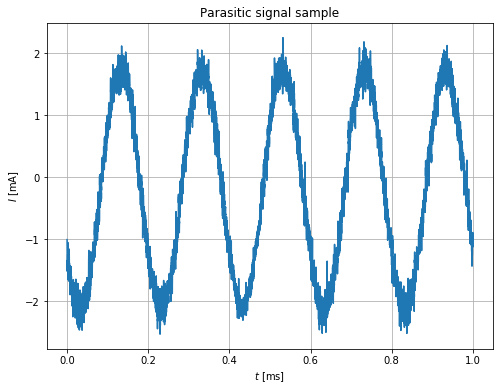

In [4]:
from urllib.request import urlopen

#Define a function for downloading single values from the GOLEM database
def get_parameter(url, shot, silent=False):
    URL = 'http://golem.fjfi.cvut.cz/shots/%i/%s' % (shot, url)
    if not silent:
        print(URL)
    f = urlopen(URL)
    try:
        return np.loadtxt(f)
    except ValueError: # the data couldn't be converted to a row of numbers
        return np.array([np.nan])

#Load the time of the thyristor opening
Tcd = get_parameter('Production/Parameters/Tcd', shot) * 1e-6 #s
TBt = get_parameter('Production/Parameters/TBt', shot) * 1e-6 #s
T0 = Tcd - TBt #time before which the parasitic signal is sampled

#Plot the parasitic signal
plt.figure('Parasitic signal sample', figsize=(8,6))
t_sample = t[t<T0] 
I_sample = I[t<T0]
plt.plot(t_sample*1000, I_sample*1000)
plt.title('Parasitic signal sample')
plt.xlabel('$t$ [ms]')
plt.ylabel('$I$ [mA]')
plt.grid(True)

We want to "clone" this sample and cover the rest of the discharge with it. To do that, we need to know exactly how long its period is. We load this from the database, where the sweeping frequency `f_fg` is stored.

In [5]:
# Load the sweeping frequency, calculate the period and print them
f = get_parameter('Diagnostics/PetiProbe/Parameters/f_fg', shot) #Hz
T = 1./f #s
print('f = %.1f kHz' % (f*1e-3))
print('T = %.3f ms' % (T*1e3))

http://golem.fjfi.cvut.cz/shots/0/Diagnostics/PetiProbe/Parameters/f_fg
f = 5.0 kHz
T = 0.200 ms


Next, we pick a few whole periods of the parasitic signal from the discharge beginning and clone the entire parasitic signal from them. Finally, we subtract the parasitic current from the total current, retrieving the probe current alone.

/home/svoboda/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/svoboda/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


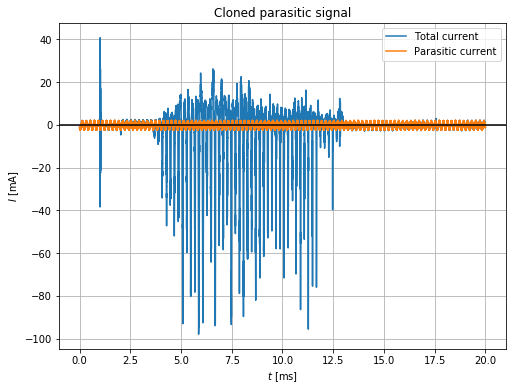

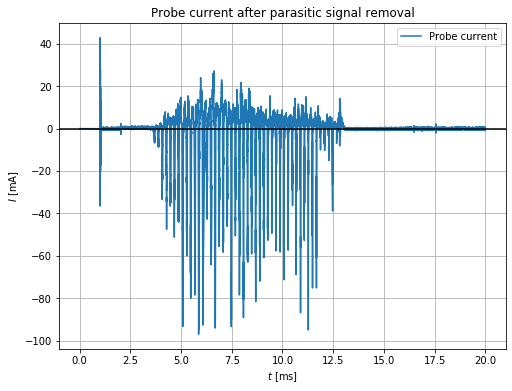

In [6]:
# Clone the parasitic current sample
n = int(np.floor(T0/T)) #number of whole periods in the parasitic signal
par_sample = I[t < T*n] #parasitic signal sample, exactly n periods long
n_final = int(np.ceil( t[-1] / (T*n) )) #number of sample repetitions required to cover the whole probe signal
par = np.hstack(n_final * [par_sample]) #extended parasitic signal covering the probe signal and a bit
par = par[:t.size] #extended parasitic signal covering exactly the whole probe signal

#Plot the total current and the parasitic current
plt.figure('Cloned parasitic signal', figsize=(8,6))
plt.title('Cloned parasitic signal')
plt.plot(t*1000, I*1000, label='Total current')
plt.plot(t*1000, par*1000, label='Parasitic current')
plt.legend()
plt.xlabel('$t$ [ms]')
plt.ylabel('$I$ [mA]')
plt.grid(True)
plt.axhline(c='k')

#Plot the probe current alone
plt.figure('Probe current after parasitic signal removal', figsize=(8,6))
plt.title('Probe current after parasitic signal removal')
I = I - par
plt.plot(t*1000, I*1000, label='Probe current')
plt.xlabel('$t$ [ms]')
plt.ylabel('$I$ [mA]')
plt.grid(True)
plt.legend()
plt.axhline(c='k')

## Cut the probe signal into individual $I-V$ characteristics

The probe current $I$ and voltage $V$ are now ready to be plotted into the $I-V$ characteristic. However, we can't mix $I-V$ characteristics from different parts of the discharge - the plasma paramaters are different and so are the $I-V$ characteristics. We need to treat them separately, and that means breaking up the signal into individual periods of the sweeping voltage.

In the following, we create a list of voltage peaks `maxima` and valleys `minima`. Specifically, we detect the first peak position in $V$ and "predict" the following peaks based on the sweeping period.

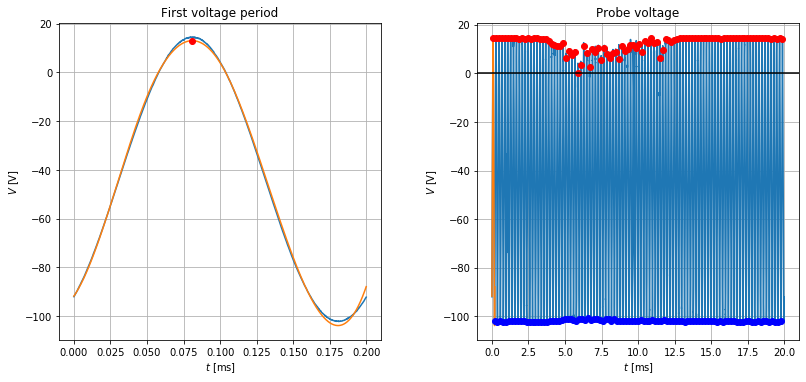

In [7]:
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline

#Prepare figure
mask = (t < T)
fig, axs = plt.subplots(1, 2, num='Probe voltage maxima detection', figsize=(11,5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

#Select the first period of the voltage signal and plot it
axs[0].set_title('First voltage period')
axs[0].plot(1000*t[mask], V[mask])
axs[0].set_xlabel('$t$ [ms]')
axs[0].set_ylabel('$V$ [V]')
axs[0].grid(True)

#Smooth the voltage and plot it
spline = UnivariateSpline(t[mask], V[mask])
V_smooth = spline(t[mask])
axs[0].plot(1000*t[mask], V_smooth)

#Find the index of its peak and plot it
peaks, _ = find_peaks(V_smooth)
first_peak_index = peaks[0]
axs[0].plot(1000*t[first_peak_index], V_smooth[first_peak_index], 'ro')

#Find the number of samples that makes up one period of the probe voltage
dt = t[1] - t[0]
N_period = int(T/dt)

#Create a list of maxima and minima indexes on the probe voltage
maxima = np.array([i*N_period for i in range(100000)]) + first_peak_index
maxima = maxima[maxima < t.size]
minima = maxima[:-1] + int(N_period/2)
extremes = np.sort(np.hstack((minima, maxima)))

#Plot the voltage maxima and minima for check
axs[1].set(title='Probe voltage', xlabel='$t$ [ms]', ylabel='$V$ [V]')
axs[1].plot(t*1000, V)
axs[1].plot(1000*t[mask], V_smooth)
axs[1].plot(1000*t[maxima], V[maxima], 'ro')
axs[1].plot(1000*t[minima], V[minima], 'bo')
axs[1].grid(True)
axs[1].axhline(c='k')
#plt.xlim(0,2)

## Plot a sample $I-V$ characteristic

As an $I-V$ characteristic example, we take the first sweeping voltage period starting after $t = 7$ ms. We plot the $I$-$V$ characteristics separately for the voltage ramp up and ramp down to show any potential hysteresis.

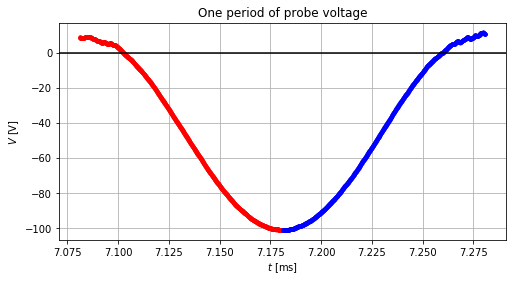

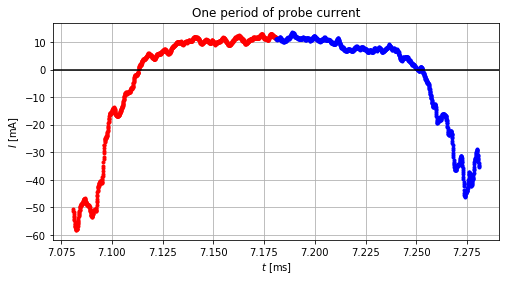

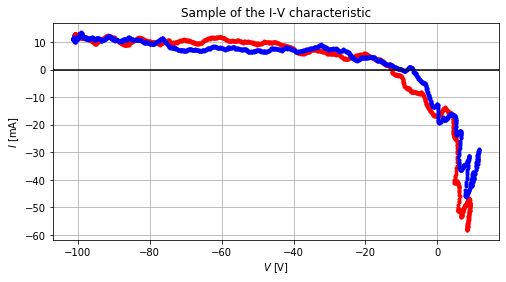

In [8]:
#Define where the sample extrema should start
t_ext = t[extremes]
sample_ext = extremes[t_ext>7e-3]

#Pick samples for the first I-V characteristic
sample_t1 = t[sample_ext[0] : sample_ext[1]]
sample_I1 = I[sample_ext[0] : sample_ext[1]]
sample_V1 = V[sample_ext[0] : sample_ext[1]]

#Pick samples for the second I-V characteristic
sample_t2 = t[sample_ext[1] : sample_ext[2]]
sample_I2 = I[sample_ext[1] : sample_ext[2]]
sample_V2 = V[sample_ext[1] : sample_ext[2]]

#Plot the time evolution of the probe voltage
plt.figure('One period of probe voltage', figsize=(8,4))
plt.title('One period of probe voltage')
plt.plot(sample_t1*1000, sample_V1, 'r.')
plt.plot(sample_t2*1000, sample_V2, 'b.')
plt.xlabel('$t$ [ms]')
plt.ylabel('$V$ [V]')
plt.grid(True)
plt.axhline(c='k')

#Plot the time evolution of the probe current
plt.figure('One period of probe current', figsize=(8,4))
plt.title('One period of probe current')
plt.plot(sample_t1*1000, sample_I1*1000, 'r.')
plt.plot(sample_t2*1000, sample_I2*1000, 'b.')
plt.xlabel('$t$ [ms]')
plt.ylabel('$I$ [mA]')
plt.grid(True)
plt.axhline(c='k')

#Plot the two I-V characteristics
plt.figure('Sample of the I-V characteristic', figsize=(8,4))
plt.title('Sample of the I-V characteristic')
plt.plot(sample_V1, sample_I1*1000, 'r.')
plt.plot(sample_V2, sample_I2*1000, 'b.')
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [mA]')
plt.grid(True)
plt.axhline(c='k')

## Apply the bin average to the $I-V$ characteristic

$I$-$V$ characteristics often contain a lot of fluctuations. This can mean that the exponential fit will not converge. In the past, when fitting techniques were slow, this was alleviated by applying the *bin average* to the data.

Bin averaging is breaking the data into individual "bin" and averaging them within that bin. Typically, the x axis (here the biasing voltage $V$) is split into even parts and all the samples within a given part (bin) are averaged. Each average is given an errorbar, calculated as the standard deviation of the averaged data. The errorbars can then be used as weights during the characteristic fitting.

Today's fitting techniques are, however, much more powerful than they used to be. Bin averaging no longer provides faster result but, on the contrary, distorts the results. This is becuase its errorbars, pretty as they are, are not very representative of the actual uncertainties in the signal. It is much better to fit the $I-V$ characteristic as we collect it, sample by sample.

We will demonstrate the difference between fitting the full and the bin-averaged $I-V$ characteristic in this notebook. Thereafter, we will use bin averaging to get a good first estimate of the plasma parameters. This can improve the fit quality of the real data.

In the following, we calculate the bin average of the two $I$-$V$ characteristics shown in the figure above.

Text(0, 0.5, '$I$ [mA]')

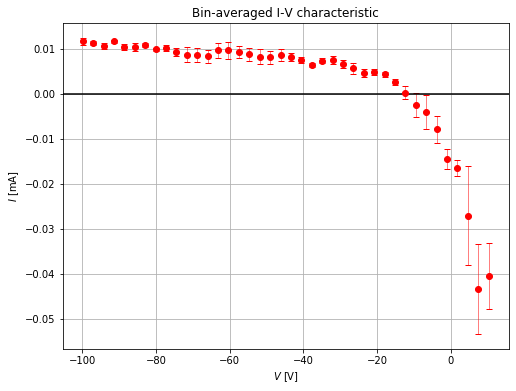

In [9]:
#Define a function which performs bin averaging
def bin_average(x, y, N_bins=100):
    dx = (np.nanmax(x) - np.nanmin(x)) / N_bins
    bins = np.linspace(np.nanmin(x) + dx/2, np.nanmax(x) - dx/2, N_bins)
    y_binned = []
    yerr = []
    for bin_centre in bins:
        y_samples = y[(bin_centre-dx/2 < x) & (x <= bin_centre+dx/2)]
        y_binned.append(np.mean(y_samples))
        yerr.append(np.std(y_samples))
    return bins, np.array(y_binned), np.array(yerr)

#Select data from both the above I-V characteristics and apply bin averaging to them
mask = slice(sample_ext[0], sample_ext[2])
V_binned, I_binned, Ierr = bin_average(V[mask], I[mask], N_bins=40)

#Plot the bin-averaged I-V characteristic
plt.figure('Bin-averaged I-V characteristic', figsize=(8,6))
plt.title('Bin-averaged I-V characteristic')
plt.errorbar(V_binned, I_binned, yerr=Ierr, color='r', marker='o', ls='None', capsize=3, elinewidth=0.5)
plt.grid(True)
plt.axhline(c='k')
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [mA]')

## Fit the bin-averaged $I-V$ characteristic

Next, we fit this binned $I$-$V$ characteristic by the exponential function and print the resulting plasma parameters.

Notice that only a part of the curve is used as fit input, in particular the data points whose probe current value is above $-2 I_{sat}$. This improves the fit stability by disregarding the more volatile datapoints near the electron branch of the $I$-$V$ characteristic.

Isat = 10.7 mA
V_fl = -12.5 V
Te = 17.3 eV


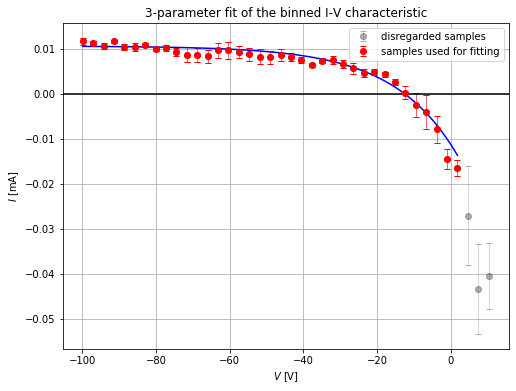

In [10]:
import scipy.optimize as optimization # for fitting

#Define the 3-parameter fit function; its arguments are a=Isat, b=Vf and c=Te
def fit3par(x,a,b,c):
    return a*(1-np.exp((x-b)/c))

#Trim the I-V characteristic
Isat_estimate = np.mean(I_binned[:20])
V_for_fit = V_binned[I_binned > -2*Isat_estimate]
I_for_fit = I_binned[I_binned > -2*Isat_estimate]
Ierr_for_fit = Ierr[I_binned > -2*Isat_estimate]

#Fit the I-V characteristic
p0 = [0.005, -5, 15] #initial guess of plasma parameters
popt, pcov = optimization.curve_fit(fit3par, V_for_fit, I_for_fit, p0, sigma=Ierr_for_fit)

#Keep a copy of the results for later
popt_bin = popt
pcov_bin = pcov

#Plot the fitted I-V characteristic
plt.figure('3-parameter fit of the binned I-V characteristic', figsize=(8,6))
plt.title('3-parameter fit of the binned I-V characteristic')
plt.errorbar(V_binned, I_binned, yerr=Ierr, color='k', marker='o', ls='None', capsize=3,
             elinewidth=0.5, alpha=0.3, label='disregarded samples')
plt.errorbar(V_for_fit, I_for_fit, yerr=Ierr_for_fit, color='r', marker='o', ls='None',
             capsize=3, elinewidth=0.5, label='samples used for fitting')
x = np.linspace(V_for_fit.min(), V_for_fit.max(), 100)
plt.plot(x, fit3par(x,*popt), color = 'b')
plt.grid(True)
plt.legend()
plt.axhline(c='k')
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [mA]')

#Print the fit results
print('Isat = %.1f mA' % (popt[0]*1000))
print('V_fl = %.1f V' % popt[1])
print('Te = %.1f eV' % popt[2])

## Fit the full $I-V$ characteristic

We use the fit of the bin-averaged data as initial guesses for the fit of the full data.

Isat = 10.7 mA (bin-averaged value: 10.7 mA)
V_fl = -13.3 V (bin-averaged value: -12.5 V)
Te = 17.0 eV (bin-averaged value: 17.3 eV)


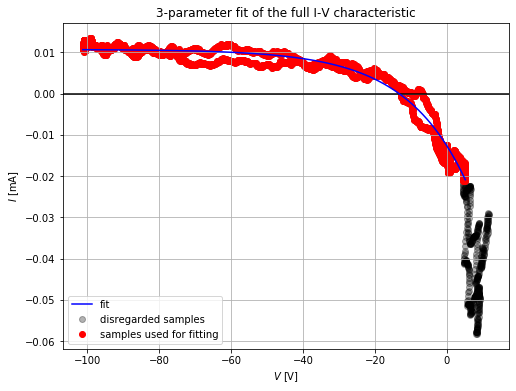

In [11]:
#Name the data to fit
V_sample = V[mask]
I_sample = I[mask]

#Trim the I-V characteristic
Isat_estimate = popt[0] #Isat of the bin-averaged I-V characteristic
V_for_fit = V_sample[I_sample > -2*Isat_estimate]
I_for_fit = I_sample[I_sample > -2*Isat_estimate]

#Fit the I-V characteristic
p0 = popt_bin #initial guess of plasma parameters
popt, pcov = optimization.curve_fit(fit3par, V_for_fit, I_for_fit, p0)

#Keep a copy of the results for later
popt_orig = popt
pcov_orig = pcov

#Plot the fitted I-V characteristic
plt.figure('3-parameter fit of the full I-V characteristic', figsize=(8,6))
plt.title('3-parameter fit of the full I-V characteristic')
plt.errorbar(V_sample, I_sample, color='k', marker='o', ls='None', alpha=0.3,
             label='disregarded samples', zorder=0)
plt.errorbar(V_for_fit, I_for_fit, color='r', marker='o', ls='None',
             label='samples used for fitting', zorder=0)
x = np.linspace(V_for_fit.min(), V_for_fit.max(), 100)
plt.plot(x, fit3par(x,*popt), color = 'b', zorder=5, label='fit')
plt.grid(True)
plt.legend()
plt.axhline(c='k')
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [mA]')

#Print the fit results
print('Isat = %.1f mA (bin-averaged value: %.1f mA)' % (popt[0]*1000, p0[0]*1000))
print('V_fl = %.1f V (bin-averaged value: %.1f V)' % (popt[1], p0[1]))
print('Te = %.1f eV (bin-averaged value: %.1f eV)' % (popt[2], p0[2]))

## Investigate the fit result errorbars with the covariance matrix

The Python fitting function `scipy.optimization.curve_fit` returns, beside the fit result values `popt`, also the so-called covariance matrix `pcov`. This is a 2D matrix whose diagonal contains the squares of the "fit error". They serve as an estimate of the fit results errorbars.

In [12]:
#Extract the diagonal components of the matrix and apply square root to them
errs = np.sqrt(pcov.diagonal())

#Print the fit results including the covariance matrix errorbars
print('Isat = %.1f +- %.1f mA (bin-averaged value: %.1f mA)' % (popt[0]*1000, errs[0]*1000, popt_bin[0]*1000))
print('V_fl = %.1f +- %.1f V (bin-averaged value: %.1f V)' % (popt[1], errs[1], popt_bin[1]))
print('Te = %.1f +- %.1f eV (bin-averaged value: %.1f V)' % (popt[2], errs[2], popt_bin[2]))

Isat = 10.7 +- 0.1 mA (bin-averaged value: 10.7 mA)
V_fl = -13.3 +- 0.1 V (bin-averaged value: -12.5 V)
Te = 17.0 +- 0.2 eV (bin-averaged value: 17.3 V)


Notice that the values obtained by fitting the bin-averaged $I-V$ characteristics may not fall within these errorbars.

These errorbars, however, may not very representative of the uncertainty of the fit results. To get a real sense for the $I_{sat}$, $V_f$ and $T_e$ uncertainty due to the data fluctuation, we employ so-called *bootstrapping*.

## Investigate the fit result errorbars with bootstraping

Bootstraping ([Wikipedia article](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))) is a simple and flexible tool for calculating errorbars. The general idea is such:

1. Calculate your quantity (here $I_{sat}$, $V_f$ and $T_e$) from your dataset (here $I-V$ characteristic).
2. Create a large number of synthetic datasets, based on the original one.
3. Calculate your quantity for each of the synthetic datasets.
4. Look how your quantity varies between these datasets.

In other words, the quantity uncertainty ($I_{sat}$, $V_f$ and $T_e$ errobars) are gauged based on how much the "synthetic" $I_{sat}$, $V_f$ and $T_e$ vary across the synthetic datasets. Bootstrapping has a lot of advantages, some of which will be showed later in the notebook. Among them is that it can be applied to *any* dataset and *any* quantity you calculate from it. It makes no assumptions on the distribution function of the data (which, in other methods, in frequently assumed to be Gaussian) and you can adjust its precision easily by changing the number of synthetic datasets. Its major drawback it that it takes a lot of time, particularly if calculating your quantity is complicated (or, God forbid, cannot be automatised). But in the case of our $I-V$ characteristics, the time needed is not that long. (In the current tests, the entire notebook takes about 30 seconds to execute on a personal computer.) Plus, the synthetic dataset are by nature independent, so the calculation can be easily parallelised.

The following function creates a number of synthetic $I-V$ characteristics (by default 100), fits them and returns the resulting 100 samples of synthetic $I_{sat}$, $V_f$ and $T_e$.

In [13]:
from arch import bootstrap

def create_bootstrap_fit_replicates(I, V, p0=[0.005, -15, 15], bss=100, b=7):
    '''
    Return three arrays of bootstrap replicates of I_sat, V_f and T_e of given I-V characteristic.
    
    p0 ... initial parameter estimates
    bss ... number of bootstrap replicates to use for errorspan calculation
    b ... average size of bootstrap block (if 0, normal sample-by-sample bootstrap is used)
    '''

    #Fit the original I-V characteristic
    popt, pcov = optimization.curve_fit(fit3par, V, I, p0)
    p0 = popt #initial guess for all the replicates

    #Prepare variables and the bootstrap iterator
    indexes = np.arange(V.size)
    if b:
        bs = bootstrap.StationaryBootstrap(b, indexes)
        #something that will provide a number of bootstrapped indexes rather quickly
    else:
        bs = bootstrap.IIDBootstrap(indexes)
        
    #Perform bootstrapping
    synthetic_results = []
    for i_bs, ((bs_indexes,),_) in enumerate(bs.bootstrap(bss)):
        #print('bootstrap', i_bs+1)
        I_bs = I[bs_indexes]
        V_bs = V[bs_indexes]
        try:
            popt, pcov = optimization.curve_fit(fit3par, V_bs, I_bs, p0)
        except RuntimeError: #the fitting goes on for too long; is probably failing
            popt = np.array([np.nan]*3)
        synthetic_results.append(popt)
    
    return np.transpose(np.array(synthetic_results))

# Create the bootstrap replicates
synth_Isat, synth_Vf, synth_Te = create_bootstrap_fit_replicates(
    I_for_fit, V_for_fit, p0=popt, bss=1000, b=5)

ModuleNotFoundError: No module named 'arch'

First we visualise the different fits by plotting them onto the $I-V$ characteristic.

In [ ]:
# Prepare the figure
fig = plt.figure('Bootstrap 3-parameter fits of the real I-V characteristic', figsize=(8,6))
fig.tight_layout()
plt.title('Bootstrap 3-parameter fit of the real I-V characteristic')

# Plot the probe data
plt.errorbar(V_for_fit, I_for_fit, color='r', marker='o', ls='None',
             label='samples used for fitting', zorder=0)

# Plot the synthetic fits
x = np.linspace(V_for_fit.min(), V_for_fit.max(), 100)
for i in range(synth_Isat.size):
    p = [synth_Isat[i], synth_Vf[i], synth_Te[i]]
    plt.plot(x, fit3par(x, *p), color='b', zorder=5, alpha=0.05)
    
# Plot the original fit and label the plot
plt.plot(x, fit3par(x, *popt_orig), color='y', zorder=10, label='original fit')
plt.grid(True)
plt.legend()
plt.axhline(c='k')
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [mA]')
plt.ylim(I_for_fit.min()-0.001, I_for_fit.max()+0.001)

Notice that the original fit (yellow) remains in the middle of all the synthetic data fits (blue). This is a general feature of bootstrapping.

Next, we investigate the fit result variability directly by plotting histograms of the synthetic values $I_{sat}$, $V_f$ and $T_e$.

In [ ]:
# Set the number of bins
N = int(np.sqrt(synth_Isat.size))

#Prepare the figure
fig, axs = plt.subplots(1, 3, num='Synthetic data histograms', figsize=(12,5), sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0)

# Draw Isat histogram
axs[0].set_title('Synthetic $I_{sat}$')
axs[0].hist(synth_Isat*1000, bins=N)
axs[0].axvline(np.nanmean(synth_Isat)*1000, c='k')
axs[0].set_xlabel('$I_{sat}$ [mA]')
axs[0].grid(True)
axs[0].set_ylabel('sample count')

# Draw Vf histogram
axs[1].set_title('Synthetic $V_f$')
axs[1].hist(synth_Vf, bins=N)
axs[1].axvline(np.nanmean(synth_Vf), c='k')
axs[1].set_xlabel('$V_f$ [V]')
axs[1].grid(True)

# Draw Te histogram
axs[2].set_title('Synthetic $T_e$')
axs[2].hist(synth_Te, bins=N)
axs[2].axvline(np.nanmean(synth_Te), c='k')
axs[2].set_xlabel('$T_e$ [eV]')
axs[2].grid(True)

Notice that the probability distributions of the synthetic fit results are Gaussian and their means are equal to the original fit values. This is another general feature of bootstrapping.

To capture the variability within these probability distributions, one can simply use the standard deviation. The distributions are Gaussian, so their variability is symmetric and a symmetric standard deviation captures it well. However, sometimes it is more informative to use an alternative - the 95% *confidence interval*.

A confidence interval ([Wikipedia page](https://en.wikipedia.org/wiki/Confidence_interval)) is a measure of variability which says "I am 95 % certain that the real value is somewhere within this interval". In other words, "ignoring the top 2.5 % and the bottom 2.5 % of values, this is the minimum and maximum value I expect from the variable". Ignoring the top and bottom 2.5 % removes the outliers (the really far-fetched variable samples) yet still captures most of the variable variability. We will test confidence intervals shortly.

## Compare various ways to calculate $I_{sat}$, $V_f$ and $T_e$ and their errobars

In the following, we compare several ways of determining the $I_{sat}$, $V_f$ and $T_e$ values and errorbars.

In [ ]:
# Results of bin averaging
errs = np.sqrt(pcov_bin.diagonal())
print('Data bin-averaged, covariance matrix errorbars:')
print('Isat = %.1f +- %.1f mA' % (popt_bin[0]*1000, errs[0]*1000))
print('V_fl = %.1f +- %.1f V' % (popt_bin[1], errs[1]))
print('Te = %.1f +- %.1f eV' % (popt_bin[2], errs[2]))

# Results of the whole data fit
errs = np.sqrt(pcov_orig.diagonal())
print('\nFull data, covariance matrix errorbars:')
print('Isat = %.1f +- %.1f mA' % (popt_orig[0]*1000, errs[0]*1000))
print('V_fl = %.1f +- %.1f V' % (popt_orig[1], errs[1]))
print('Te = %.1f +- %.1f eV' % (popt_orig[2], errs[2]))

# Results of bootstrap with standard deviation errorbars
print('\nFull data, bootstrap fits with standard deviation errorbars:')
print('Isat = %.1f +- %.1f mA' % (synth_Isat.mean()*1000, synth_Isat.std()*1000))
print('V_fl = %.1f +- %.1f V' % (synth_Vf.mean(), synth_Vf.std()))
print('Te = %.1f +- %.1f eV' % (synth_Te.mean(), synth_Te.std()))

# Results of bootstrap with 95% confidence intervals
print('\nFull data, bootstrap fits with 95% confidence intervals:')
print('Isat = %.1f mA (%.1f to %.1f mA)' % (synth_Isat.mean()*1000,
    np.percentile(synth_Isat, 2.5)*1000, np.percentile(synth_Isat, 97.5)*1000))
print('V_fl = %.1f V (%.1f to %.1f V)' % (synth_Vf.mean(),
    np.percentile(synth_Vf, 2.5), np.percentile(synth_Vf, 97.5)))
print('Te = %.1f eV (%.1f to %.1f eV)' % (synth_Te.mean(),
    np.percentile(synth_Te, 2.5), np.percentile(synth_Te, 97.5)))

Which method you pick depends, generally, on the kind of data you have. Can you afford to make a lot of synthetic bootstrap datasets? What kind of plots do you want to make with the data? How much do you need to trust the results? In this notebook, we will go with the third option and take the standard deviation of the bootstrapped $I_{sat}$, $V_f$ and $T_e$ as the errorbars. This is, in part, because I'm a bit too lazy to deal with asymmetric Y axis errors at the moment. (Plus the symmetric standard deviation is easier to read.)

## Check correlations between the fit results

There is one more thing to consider when judging the fit results uncertainty. Since $I_{sat}$, $V_f$ and $T_e$ come from a single fit, there can be trade-offs between them. For instance, a decrease in $I_{sat}$ may be partially compensated by a decrease in $T_e$. This correlation increases the overall uncertainty. Sadly, at the moment I don't know how to calculate exactly how much. So let's just plot the scatterplots and see if $I_{sat}$, $V_f$ and $T_e$ are correlated within a single $I-V$ characteristic and its synthetic replicates. The red star denotes the results of the original fit of the full data.

In [ ]:
# Prepare the figure
fig, axs = plt.subplots(1, 3, num='Synthetic data scatterplots', figsize=(12,5), constrained_layout=True)
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.3)

# Draw Isat x Te scatterplot
axs[0].set_title('Synthetic $I_{sat}$ vs $T_e$')
c0 = axs[0].scatter(synth_Isat*1000, synth_Te, marker='v', c=synth_Vf)
axs[0].plot([popt_orig[0]*1000], [popt_orig[2]], 'r*')
axs[0].set_xlabel('$I_{sat}$ [mA]')
axs[0].set_ylabel('$T_e$ [eV]')
axs[0].grid(True)
cbar = fig.colorbar(c0, ax=axs[0], orientation='horizontal')
cbar.set_label('$V_f$ [V]')

# Draw Vf x Te histogram
axs[1].set_title('Synthetic $V_f$ vs $T_e$')
c1 = axs[1].scatter(synth_Vf, synth_Te, marker='v', c=synth_Isat*1000)
axs[1].plot([popt_orig[1]], [popt_orig[2]], 'r*')
axs[1].set_xlabel('$V_f$ [V]')
axs[1].set_ylabel('$T_e$ [eV]')
axs[1].grid(True)
cbar = fig.colorbar(c1, ax=axs[1], orientation='horizontal')
cbar.set_label('$I_{sat}$ [mA]')

# Draw Isat x Vf histogram
axs[2].set_title('Synthetic $I_{sat}$ vs $V_f$')
c2 = axs[2].scatter(synth_Isat*1000, synth_Vf, marker='v', c=synth_Te)
axs[2].plot([popt_orig[0]*1000], [popt_orig[1]], 'r*')
axs[2].set_xlabel('$I_{sat}$ [mA]')
axs[2].set_ylabel('$V_f$ [V]')
axs[2].grid(True)
cbar = fig.colorbar(c2, ax=axs[2], orientation='horizontal')
cbar.set_label('$T_e$ [eV]')

We can see that the fit results *are*, indeed, correlated. In particular, an increase in $T_e$ can be compensated by an increase in $I_{sat}$ or a decrease in $V_f$. The latter two, $I_{sat}$ and $V_f$, are not strongly correlated. This means that the variation in $T_e$ is, in part, not caused by the probe data fluctuation but by the variation of $I_{sat}$ and $V_f$. This finding requires more in-depth analysis to properly acknowledge in the errobars used in this notebook, so we leave it here as a point of interest and future research.



## Fit all $I-V$ characteristics throughout the discharge

Finally, we perform the fitting procedure described above throughout the discharge. The process is fully automatic. Occasionally the fit doesn't converge; this will be treated later.

In [ ]:
# Define fit constants
start = get_parameter('Diagnostics/BasicDiagnostics/Results/t_plasma_start', shot) * 1e-3 #s
end = get_parameter('Diagnostics/BasicDiagnostics/Results/t_plasma_end', shot) * 1e-3 #s
n = 2 #number of I-V characteristics to bin together

# Perform the fitting
extremes_for_calculation = extremes[(start < t_ext) & (t_ext < end)]
fit_results = []
for i in range(extremes_for_calculation.size-n):
    #Select full data sample
    k1 = extremes_for_calculation[i] #index of the sample beginning
    k2 = extremes_for_calculation[i+n] #index of the sample end
    V_sample = V[k1 : k2]
    I_sample = I[k1 : k2]
    
    #Perform bin averaging and fit the I-V characteristic as first guess
    Isat_estimate = np.mean(I_sample[I_sample > 0])
    mask = (I_binned > -2*Isat_estimate)
    V_binned, I_binned, Ierr = bin_average(V_sample, I_sample, N_bins=40)
    popt, pcov = optimization.curve_fit(fit3par, V_binned[mask], I_binned[mask], p0, sigma=Ierr[mask])
    
    #Fit the full data
    Isat_estimate = popt[0]
    mask = (I_sample > -2*Isat_estimate)
    popt, pcov = optimization.curve_fit(fit3par, V_sample[mask], I_sample[mask], popt)
    
    #Create synthetic fit results using bootstrapping and process them for errorbars
    synth_Isat, synth_Vf, synth_Te = create_bootstrap_fit_replicates(
        I_sample[mask], V_sample[mask], p0=popt, bss=100, b=5)
    err = [synth_Isat.std(), synth_Vf.std(), synth_Te.std()]
    fit_results.append(list(popt)+err)

#Compile the fit results
fit_results = np.transpose(np.array(fit_results))
Isat, V_f, Te, Isat_err, Vf_err, Te_err = fit_results
t_fit = np.convolve(t[extremes_for_calculation][:-1], np.ones(n), 'valid') / n + T/4
    # moving average of t_ext by n samples, except for the last, closing extreme
    # middle of the window where the used I-V characteristics were collected

To improve the data quality, we remove the results where the fit evidently failed.

In [ ]:
#Create a mask of results to be kept
mask = np.array([True]*Isat.size)

#Throw out fit results with larger than 50 % errorbar in Isat or Te
# (not V_f, since that can be expected to pass through 0)
mask = mask & (Isat_err < 0.5*abs(Isat)) &  (Te_err < 0.5*abs(Te))

#Throw out fit results with unreasonable/unphysical values
mask = mask & (Isat > 0) & (Isat < 0.03)
mask = mask & (V_f > -100) & (V_f < 30)
mask = mask & (Te > 0) & (Te < 100)

#Remove fits which don't meet all the criteria
Isat[~mask] = np.nan
V_f[~mask] = np.nan
Te[~mask] = np.nan
print('%i %% of the fits did not converge.' % (np.sum(~mask)/Isat.size * 100))

We save the data.

Finally, let's plot the time evolution of the fit results - edge plasma parameters $I_{sat}$, $V_f$ and $T_e$ - during the whole discharge.

In [ ]:
#Prepare figure
fig, axs = plt.subplots(3, 1, num='Time evolution of fit results', figsize=(8,8), sharex=True)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#Plot the ion saturated current
axs[0].errorbar(1000*t_fit, Isat*1000, color='g', marker='o', yerr=Isat_err*1000,
               label='Ion saturation current', ls='None', capsize=3, elinewidth=0.5)
axs[0].grid(True)
axs[0].axhline(c='k')
axs[0].set(ylabel='$I_{sat}$ [mA]', title='Swept Langmuir probe results, discharge #%i' % shot)
axs[0].legend(loc=1)

#Plot the floating potential
axs[1].errorbar(1000*t_fit, V_f, color='b', marker='o', yerr=Vf_err,
               label='Floating potential', ls='None', capsize=3, elinewidth=0.5)
axs[1].grid(True)
axs[1].axhline(c='k')
axs[1].set(ylabel='$V_f$ [V]')
axs[1].legend(loc=1)

#Plot the electron temperature
axs[2].errorbar(1000*t_fit, Te, color='r', marker='o', yerr=Te_err,
               label='Electron temperature', ls='None', capsize=3, elinewidth=0.5)
axs[2].grid(True)
axs[2].axhline(c='k')
axs[2].set(xlabel='$t$ [ms]', ylabel='$T_e$ [eV]')
axs[2].legend(loc=1)

# Save the figure
plt.savefig('icon-fig')